### Sample program for Factor Analysis  

#### Import libraries  

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from factor_analyzer import FactorAnalyzer

#### Parameters  

In [2]:
csv_in = '../characteristics.csv'

%config InlineBackend.figure_formats = {'png', 'retina'}  # for high-reso graph

#### Read CSV data  

In [3]:
df = pd.read_csv(csv_in, delimiter=',', skiprows=0, header=0)
print(df.shape)
print(df.info())
display(df.head())

(20, 7)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype
---  ------       --------------  -----
 0   ID           20 non-null     int64
 1   Friendly     20 non-null     int64
 2   Active       20 non-null     int64
 3   Social       20 non-null     int64
 4   Logical      20 non-null     int64
 5   Intelligent  20 non-null     int64
 6   Curious      20 non-null     int64
dtypes: int64(7)
memory usage: 1.2 KB
None


,ID,Friendly,Active,Social,Logical,Intelligent,Curious
0,1,5,5,6,6,6,9
1,2,10,10,7,4,2,5
2,3,7,8,7,1,3,2
3,4,4,4,1,5,5,6
4,5,4,4,6,9,9,9


In [10]:
df = df.loc[:, 'Friendly':]
display(df.head())

,Friendly,Active,Social,Logical,Intelligent,Curious
0,5,5,6,6,6,9
1,10,10,7,4,2,5
2,7,8,7,1,3,2
3,4,4,1,5,5,6
4,4,4,6,9,9,9


#### Factor analysis  

In [11]:
fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='ml')
#fa = FactorAnalyzer(n_factors=2, rotation='varimax', method='minres')
fa.fit(df.values)

FactorAnalyzer(method='ml', n_factors=2, rotation='varimax', rotation_kwargs={})

#### Correlation matrix (相関行列)   

In [12]:
df_corr = df.corr(method='pearson')
display(df_corr)

,Friendly,Active,Social,Logical,Intelligent,Curious
Friendly,1.000000,0.874059,0.679350,0.137719,0.180420,0.259846
Active,0.874059,1.000000,0.651193,0.045109,0.083048,0.173865
Social,0.679350,0.651193,1.000000,0.119059,0.101711,0.167588
Logical,0.137719,0.045109,0.119059,1.000000,0.845708,0.846972
Intelligent,0.180420,0.083048,0.101711,0.845708,1.000000,0.701075
Curious,0.259846,0.173865,0.167588,0.846972,0.701075,1.000000


#### Eigenvalues (固有値)  

In [13]:
eigen_org, eigen_cf = fa.get_eigenvalues()
ser_eigen_org = pd.Series(eigen_org)
ser_eigen_cf = pd.Series(eigen_cf)
print(ser_eigen_org)
print(ser_eigen_cf)

0    2.967442
1    2.118540
2    0.406357
3    0.294477
4    0.120607
5    0.092577
dtype: float64
0    2.776051
1    1.929582
2    0.029607
3    0.025458
4   -0.002679
5   -0.037833
dtype: float64


#### Scree plot (スクリープロット)  

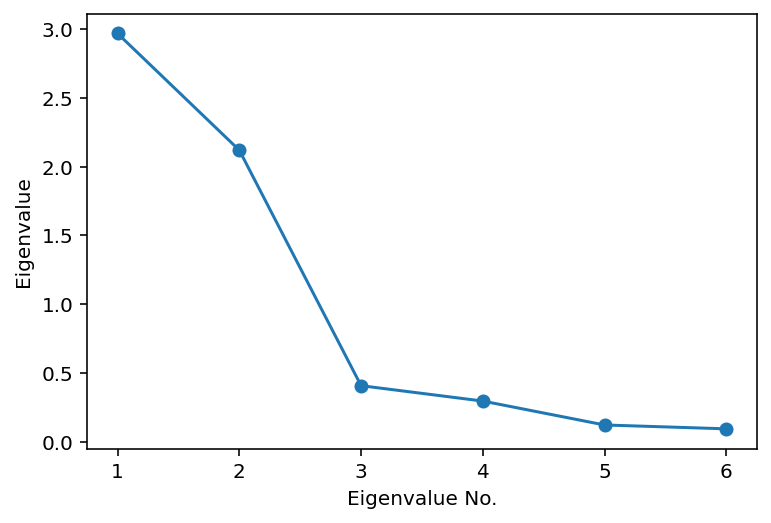

In [14]:
x = np.array(range(len(ser_eigen_org)))+1
plt.plot(x, ser_eigen_org, marker='o')
plt.xlabel('Eigenvalue No.')
plt.ylabel('Eigenvalue')
plt.show()

**Number of factors: two seems to be appropriate because the third eigenvalue is less than 1 and also the graph becomes gently-sloping at the third eigenvalue.**  
**3つめの固有値は1を下回っていて、かつそこからグラフがなだらかになっているので、因子数は2が良さそう**  

#### Loadings (因子負荷量)  

In [15]:
loadings = fa.loadings_
df_loadings = pd.DataFrame(loadings, index=df.columns,
                           columns=['Factor1','Factor2'])
display(df_loadings)

,Factor1,Factor2
Friendly,0.109722,0.952249
Active,0.017625,0.916514
Social,0.097145,0.702600
Logical,0.997053,0.029957
Intelligent,0.845326,0.082194
Curious,0.843909,0.171611


#### Scores (因子得点)  

In [16]:
scores = fa.transform(df)
df_scores = pd.DataFrame(scores, columns=['Factor1','Factor2'])
print(df_scores.shape)
display(df_scores.head())

(20, 2)


,Factor1,Factor2
0,0.079606,-0.589200
1,-0.923340,1.183815
2,-2.257365,0.387283
3,-0.379363,-1.037830
4,1.459282,-1.075586


#### Uniquenesses (独自因子の割合)  

In [17]:
uniqueness = fa.get_uniquenesses()
ser_uniqueness = pd.Series(uniqueness, index=df.columns)
print(ser_uniqueness)

Friendly       0.081183
Active         0.159691
Social         0.496915
Logical        0.004987
Intelligent    0.278667
Curious        0.258368
dtype: float64


**Not so high uniqueness for all data,  
so all data are somehow affected by the common factors**

#### Contribution of each factor (各共通因子の寄与)  
- Variance: 因子負荷量平方和(因子寄与)  
- Proportion Var: 寄与率  
- Cumulative Var: 累積寄与率

In [18]:
fa_var = fa.get_factor_variance()
df_fa_var = pd.DataFrame(fa_var,
                         index=['var', 'prop_var', 'cum_var'],
                         columns=['Factor1', 'Factor2'])
display(df_fa_var)

,Factor1,Factor2
var,2.44266,2.277527
prop_var,0.40711,0.379588
cum_var,0.40711,0.786698


**More than 78% of total variance can be explained by Factor1 and Factor2**  

In [19]:
# slightly modified from biplot() in pca_and_biplot.ipynb of DM-08
def biplot_fa(score_2d, loadings, load_labels=None):
    plt.figure(figsize=(10,10))
    r1 = 1.5
    r2 = 1.01
    if load_labels is None:
        load_labels = range(len(loadings))
    for i, coef in enumerate(loadings):
        plt.arrow(0, 0, coef[0]*r1, coef[1]*r1, color='r')    
        plt.text(coef[0]*r1*r2, coef[1]*r1*r2, load_labels[i],
                 color='b', fontsize=20)
    for i in range(len(score_2d)):
        m = '${}$'.format(i)
        plt.scatter(score_2d[i,0], score_2d[i,1], marker=m, s=500, c='k')
    plt.xlabel('F_1')
    plt.ylabel('F_2')
    plt.grid()
    return None

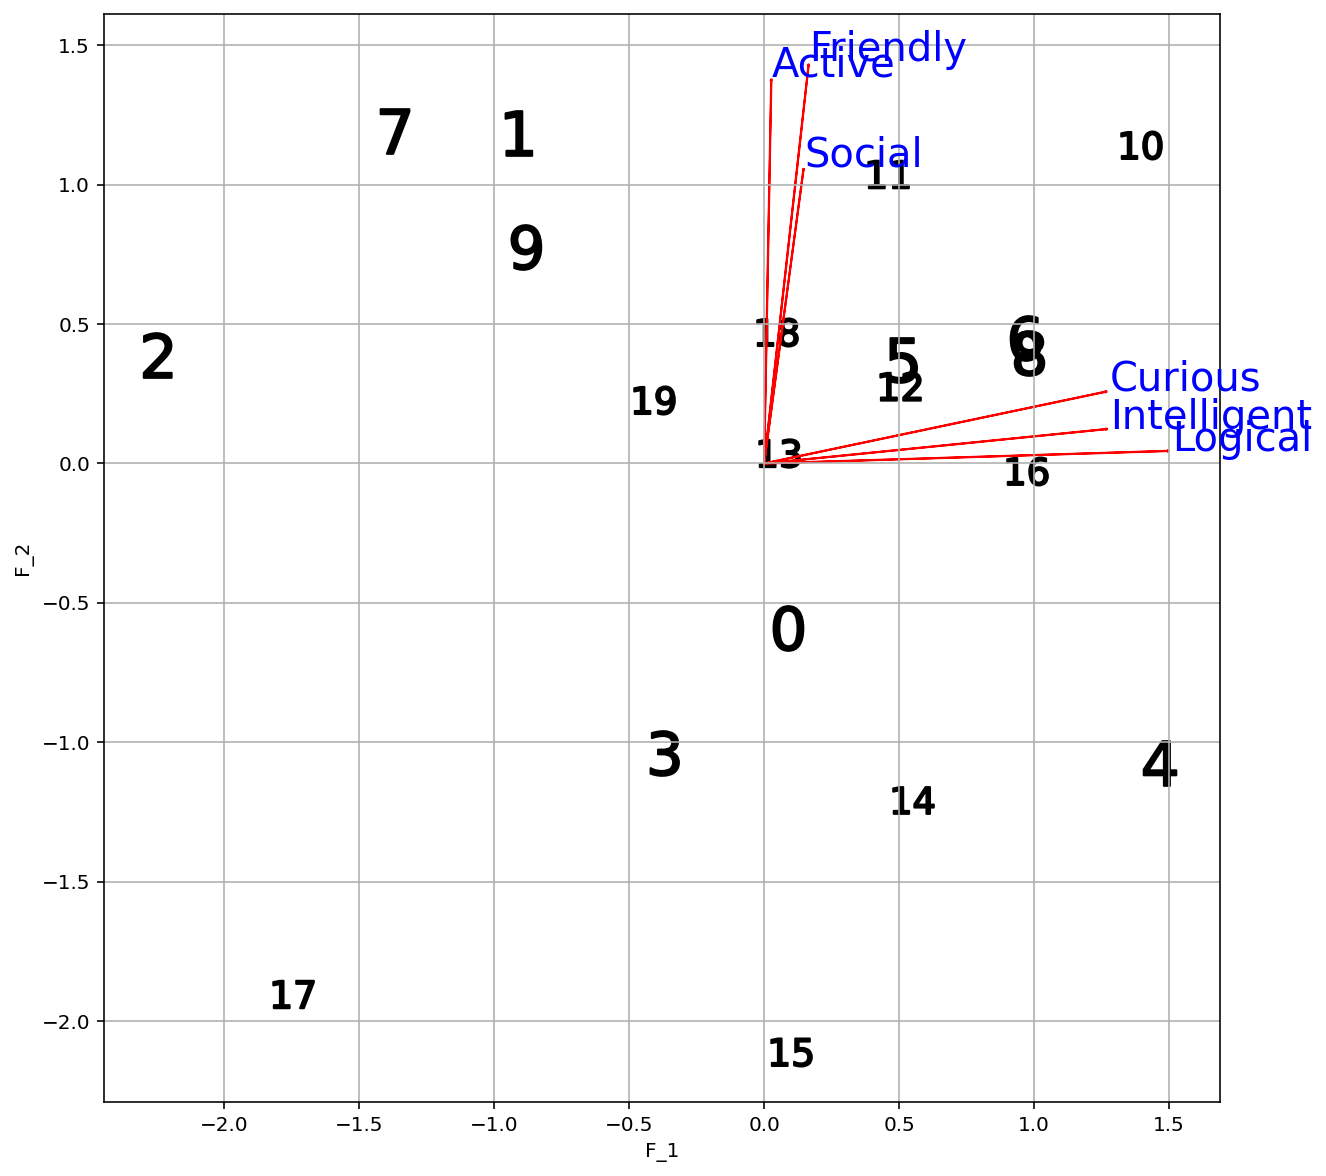

In [20]:
biplot_fa(scores, loadings, load_labels=df.columns)